### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML, Image

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

#%run Visualizer.py # --allows for reloading the particular code

#### Train the network

In [2]:
n = 10
popsize = 10
generations = 100
wrap_around = True
name = 'centered8'
#device = torch.device('mps:0')
device = torch.device('cpu')
#trainer = Evo_Trainer(n, device)
trainer = Evo_Trainer(n, device, popsize)

2023-02-22 20:43:51,766	INFO worker.py:1528 -- Started a local Ray instance.


[2023-02-22 20:43:54] INFO     <49930> evotorch.core: Instance of `Custom_NEProblem` (id:4367506480) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-02-22 20:43:54] INFO     <49930> evotorch.core: Instance of `Custom_NEProblem` (id:4367506480) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-02-22 20:43:54] INFO     <49930> evotorch.core: Instance of `Custom_NEProblem` (id:4367506480) -- The `device` of the problem is set as cpu
[2023-02-22 20:43:54] INFO     <49930> evotorch.core: Instance of `Custom_NEProblem` (id:4367506480) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-02-22 20:43:54] INFO     <49930> evotorch.core: Instance of `Custom_NEProblem` (id:4367506480) -- Number of GPUs that will be allocated per actor is None


In [3]:
trainer.train(generations, name)

              iter : 1
obj0_pop_best_eval : 4.0
  obj0_median_eval : 0.0
    obj0_mean_eval : 0.6050000190734863
obj1_pop_best_eval : 0.002337272511795163
  obj1_median_eval : 7.839006423950195
    obj1_mean_eval : 4.142252445220947
obj2_pop_best_eval : 7.708000183105469
  obj2_median_eval : 2.631999969482422
    obj2_mean_eval : 2.883960008621216
obj3_pop_best_eval : 0.0
  obj3_median_eval : 42.142696380615234
    obj3_mean_eval : 48.250205993652344
obj4_pop_best_eval : 8.233125299739186e-06
  obj4_median_eval : 0.01700827293097973
    obj4_mean_eval : 0.13218289613723755

              iter : 2
obj0_pop_best_eval : 6.0
  obj0_median_eval : 1.0
    obj0_mean_eval : 0.8349999785423279
obj1_pop_best_eval : 0.002337272511795163
  obj1_median_eval : 8.161476135253906
    obj1_mean_eval : 6.541477203369141
obj2_pop_best_eval : 7.461999893188477
  obj2_median_eval : 2.309999942779541
    obj2_mean_eval : 2.5958502292633057
obj3_pop_best_eval : 0.0
  obj3_median_eval : 39.65172576904297
    

In [4]:
network = trainer.get_trained_network()

In [5]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'][0])
#network = trainer.problem.parameterize_net(trainer.searcher.status['center'][0])
network = trainer.problem.parameterize_net(trainer.searcher.status['obj0_pop_best'])
#network = trainer.problem.parameterize_net(trainer.searcher.status['obj4_pop_best'])

In [6]:
#trainer.searcher.status

#### Visualize trained network

In [7]:
organism = generate_organism(n, device)
graph = organism.toGraph()
visualizer = Visualizer(wrap_around)
network(graph, 0)

(Data(x=[30, 10], edge_index=[1, 0], device=cpu, attr=[1]),
 tensor([0., 0.]),
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0)

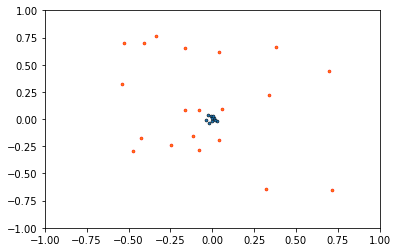

In [8]:
anim = visualizer.animate_organism(graph, network, food=30, frames=100)
visualizer.save_animation_to_gif(anim, name, 10)

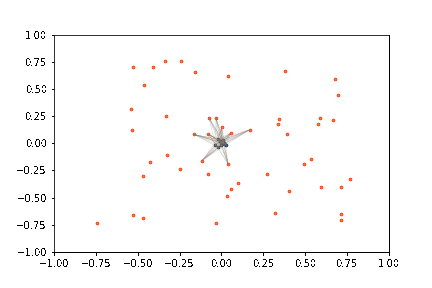

In [9]:
Image('../animation/' + name + '.gif')

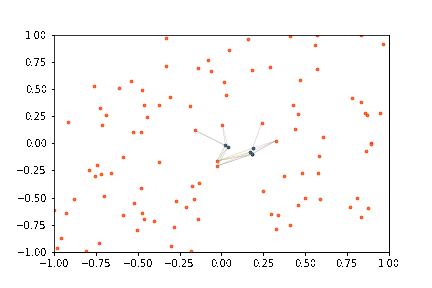

In [10]:
Image('../animation/GATConv1.gif')

In [11]:
anim.frame_seq = anim.new_saved_frame_seq() 
IPython.display.HTML(anim.to_jshtml())

In [12]:
print(network)

CGConv1(
  (conv_layer_cells): CGConv(8, dim=4)
  (conv_layer_food): CGConv(8, dim=4)
  (mlp_before): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): Tanh()
  )
  (mlp_middle): Sequential(
    (0): Tanh()
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Tanh()
  )
  (mlp): Sequential(
    (0): Tanh()
    (1): Linear(in_features=8, out_features=4, bias=True)
    (2): Tanh()
  )
  (gConvGRU): GConvGRU(
    (conv_x_z): ChebConv(8, 8, K=1, normalization=sym)
    (conv_h_z): ChebConv(8, 8, K=1, normalization=sym)
    (conv_x_r): ChebConv(8, 8, K=1, normalization=sym)
    (conv_h_r): ChebConv(8, 8, K=1, normalization=sym)
    (conv_x_h): ChebConv(8, 8, K=1, normalization=sym)
    (conv_h_h): ChebConv(8, 8, K=1, normalization=sym)
  )
)


In [13]:
print('conv_layers1: ', network.conv_layer_cells)
for param in network.conv_layer_cells.parameters():
  print(param.data)

print('conv_layers2: ', network.conv_layer_food)
for param in network.conv_layer_food.parameters():
  print(param.data)

conv_layers1:  CGConv(8, dim=4)
tensor([[ 0.0091,  0.0313, -0.0751, -0.0164,  0.0052,  0.0172,  0.0299, -0.0060,
         -0.0176,  0.0426,  0.0109,  0.0064, -0.0269, -0.0072,  0.0326,  0.0851,
         -0.0025, -0.0155,  0.0477, -0.0254],
        [-0.0197,  0.0224,  0.0035, -0.0040,  0.0013,  0.0127, -0.0464, -0.0189,
         -0.0268, -0.0266,  0.0059, -0.0199, -0.0224,  0.0005,  0.0072, -0.0231,
          0.0396,  0.0030, -0.0065, -0.0204],
        [ 0.0277,  0.0052, -0.0477,  0.0121,  0.0222, -0.0205, -0.0090, -0.0181,
         -0.0284,  0.0355, -0.0163, -0.0088,  0.0660, -0.0018, -0.0121,  0.0309,
          0.0288, -0.0149,  0.0320,  0.0079],
        [-0.0284,  0.0350,  0.0126,  0.0419, -0.0312, -0.0020, -0.0450, -0.0442,
          0.0137,  0.0248, -0.0249, -0.0108, -0.0403,  0.0013,  0.0251, -0.0189,
         -0.0139,  0.0348,  0.0604,  0.0434],
        [ 0.0335, -0.0135,  0.0152, -0.0115,  0.0320, -0.0131, -0.0145,  0.0202,
          0.0120,  0.0435, -0.0449,  0.0468, -0.0101, -

In [14]:
print('GConvGRU: ', network.gConvGRU)
for param in network.gConvGRU.parameters():
  print(param.data)


GConvGRU:  GConvGRU(
  (conv_x_z): ChebConv(8, 8, K=1, normalization=sym)
  (conv_h_z): ChebConv(8, 8, K=1, normalization=sym)
  (conv_x_r): ChebConv(8, 8, K=1, normalization=sym)
  (conv_h_r): ChebConv(8, 8, K=1, normalization=sym)
  (conv_x_h): ChebConv(8, 8, K=1, normalization=sym)
  (conv_h_h): ChebConv(8, 8, K=1, normalization=sym)
)
tensor([-0.0054,  0.0282, -0.0036, -0.0059, -0.0066,  0.0154, -0.0253, -0.0216])
tensor([[-0.0298, -0.0195, -0.0197,  0.0154,  0.0270,  0.0287,  0.0045,  0.0292],
        [-0.0913,  0.0063, -0.0270,  0.0292, -0.0012,  0.0134, -0.0423, -0.0217],
        [-0.0417, -0.0399,  0.0032,  0.0222, -0.0234, -0.0155, -0.0393, -0.0125],
        [-0.0005,  0.0179,  0.0132,  0.0057, -0.0185,  0.0036, -0.0222,  0.0494],
        [ 0.0047, -0.0080, -0.0160, -0.0132,  0.0010,  0.0093, -0.0142, -0.0085],
        [-0.0024, -0.0358,  0.0770, -0.0027,  0.0059, -0.0002, -0.0276,  0.0074],
        [-0.0419,  0.0253, -0.0258,  0.0367, -0.0403, -0.0349, -0.0028,  0.0375],
    

In [15]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

In [16]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
print(losses)
#plt.plot(losses.stepsize)

#plt.plot(losses.median_eval)
#plt.plot(losses.pop_best_eval)
#plt.plot(losses.mean_eval)
#plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()

      obj0_pop_best_eval  obj0_median_eval  obj0_mean_eval  \
iter                                                         
1                    4.0               0.0           0.605   
2                    6.0               1.0           0.835   
3                    3.0               0.0           0.685   
4                    4.0               1.0           0.890   
5                    4.0               1.0           0.935   
...                  ...               ...             ...   
96                   4.0               1.0           0.975   
97                   4.0               1.0           0.860   
98                   4.0               1.0           0.965   
99                   4.0               1.0           0.915   
100                  4.0               1.0           0.850   

      obj1_pop_best_eval  obj1_median_eval  obj1_mean_eval  \
iter                                                         
1               0.002337          7.839006        4.142252   
2      

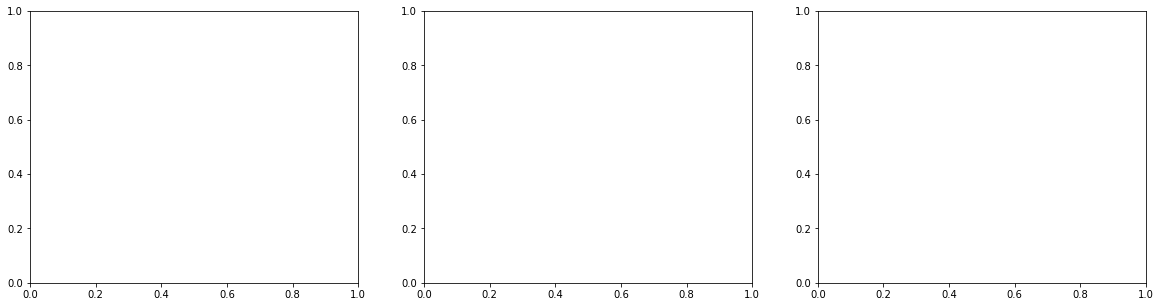

In [17]:
trainer.logger_df
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle('')
plt.show()